In [29]:
import nengo
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
import os
from nengo.dists import Choice
from datetime import datetime
from nengo_extras.data import load_mnist
import pickle
from nengo.utils.matplotlib import rasterplot

plt.rcParams.update({'figure.max_open_warning': 0})

from InputData import PresentInputWithPause
# import nengo_ocl

In [61]:
#############################
# load the data
#############################

img_rows, img_cols = 28, 28
input_nbr = 20

(image_train, label_train), (image_test, label_test) = (tf.keras.datasets.mnist.load_data())

#select the 0s and 1s as the two classes from MNIST data
image_train_filtered = []
label_train_filtered = []

# x = 6

# for i in range(0,input_nbr):
#   if label_train[i] == x:
#         image_train_filtered.append(image_train[i])
#         label_train_filtered.append(label_train[i])
#         if x == 6:
#             x = 9
#         else:
#             x = 6

for i in range(0,input_nbr):
    image_train_filtered.append(image_train[i])
    label_train_filtered.append(label_train[i])

image_train_filtered = np.array(image_train_filtered)
label_train_filtered = np.array(label_train_filtered)

In [62]:
#############################
# Helpfull methodes
#############################

def sparsity_measure(vector):  # Gini index
    # Max sparsity = 1 (single 1 in the vector)
    v = np.sort(np.abs(vector))
    n = v.shape[0]
    k = np.arange(n) + 1
    l1norm = np.sum(v)
    summation = np.sum((v / l1norm) * ((n - k + 0.5) / n))
    return 1 - 2 * summation

def HeatMapSave(network,name,probe,samples=1,neuron=1):
    x = int(samples/100)

    if not os.path.exists(name):
        os.makedirs(name)

    plt.matshow(np.reshape(network.data[probe][:,neuron][samples-1],(28,28)))
    plt.title(samples-1)
    plt.savefig(name+"/"+str(neuron)+":"+str(samples-1)+".png")
    plt.cla()

def AllHeatMapSave(network,probe,folder,samples=1,neuron=1):

    if not os.path.exists(folder):
        os.makedirs(folder)
    
    os.makedirs(folder+"/"+str(neuron))
    i = 0
    step = samples / 100
    while i < samples:
        plt.matshow(np.reshape(network.data[probe][:,neuron][i],(28,28))) # , cmap=cm.jet
        plt.title(i)
        plt.savefig(folder+"/"+str(neuron)+"/"+str(neuron)+":"+str(i)+".png")
        plt.cla()
        i = int(i + step)


In [63]:
# def fun(X,
#        a1=0,a2=1,a3=0,
#        b1=1,b2=1,b3=1,b4=1,b5=1,b6=1,b7=1,
#        c1=0,c2=1,c3=0,
#        d1=1,d2=1,d3=1,d4=1,d5=1,d6=1,d7=1,
#        e1=0, e2=0, e3=0, e4=0,e5=0,e6=0,
#        alpha1=1,alpha2=0    
#        ): 
#             w, vmem = X
#             w=np.array(w)
#             vmem=np.array(vmem)
#             vthp=0.25
#             vthn=0.25
#             vprog=1
#             w_pos = e1*w + e3
#             w_neg = e2*(1-w) + e4
#             v_ov_p =  vmem - (vprog+vthp) + e5
#             v_ov_n = (vprog-vthn) - vmem  + e6
#             cond_1 = vmem<(vprog-vthn)
#             cond_2 = vmem>(vprog+vthp)
#             f1 = a1 + a2*(w_pos**1) + a3*(w_pos**2)
#             g1 = b1 + b2*np.sin(b3*v_ov_n + b4) + b5*np.cos(b6*v_ov_n + b7)
#             f2 = c1 + c2*(w_neg**1) + c3*(w_neg**2)
#             g2 = d1 + d2*np.sin(d3*v_ov_p + d4) + d5*np.cos(d6*v_ov_p + d7)
#             dW = (-1*cond_1*(alpha1*f1*g1))  + (cond_2*(alpha2*cond_2*f2*g2))    
#             return dW
        
# popt = np.array((-0.63268079,  1.92345965,  0.47470475,  0.08882345,  2.65286122,
#        -3.50470788, -1.04094917,  2.46161541,  3.63797126, -0.54362876,
#        -0.71246513,  3.70078799,  0.13785252, -2.05963654,  3.14470144,
#         0.66939748,  0.37730831,  1.06771835,  1.13675002,  1.12284471,
#         1.76493531,  3.54101003,  0.21334419,  0.16327218,  1.17173351,
#        -0.3972994 , -1.62356781,  3.47649959))

# class CustomRule(nengo.Process):
   
#     def __init__(self, vthp=0.25, vthn=0.25, vprog=1,winit_min=0, winit_max=1):
       
#         self.vthp = vthp
#         self.vthn = vthn
#         self.vprog = vprog  
#         self.signal = None
#         self.history = []
#         self.update_history = []
        
#         self.vmem_prev = 0
        
#         self.winit_min = winit_min
#         self.winit_max = winit_max
        
#         self.tstep=0 #Just recording the tstep to sample weights. (To save memory)
        
#         super().__init__()
        
#     def make_step(self, shape_in, shape_out, dt, rng, state=None):  
       
#         self.w = np.random.uniform(self.winit_min, self.winit_max, (shape_out[0], shape_in[0]))
#         dw = np.ones((shape_out[0], shape_in[0]))

#         def step(t, x):

#             assert self.signal is not None
#             vmem = self.signal           
#             for n_out in range(shape_out[0]):
#                 vmem = self.signal[n_out]
#                 for n_in in range(shape_in[0]):  
#                     dw[n_out][n_in] = x[n_in]*dt*fun((self.w[n_out][n_in],vmem*2),*popt)
           
#             self.w += dw                                     
# #             self.history = np.array(self.history.append(self.w.copy()))
# #             self.history = np.array(self.history)
            
#             if (self.tstep%100 ==0):
#                 self.history.append(self.w.copy())
#                 self.update_history.append(dw.copy())
#             self.vmem_prev = vmem.copy()
#             self.tstep +=1
#             return np.dot(self.w, x)
        
#         return step   
    
#     def set_signal(self, signal):
#         self.signal = signal

In [84]:
def fun(X,
       a1=0,a2=1,a3=0,
       b1=1,b2=1,b3=1,b4=1,b5=1,b6=1,b7=1,
       c1=0,c2=1,c3=0,
       d1=1,d2=1,d3=1,d4=1,d5=1,d6=1,d7=1,
       e1=0, e2=0, e3=0, e4=0,e5=0,e6=0,
       alpha1=1,alpha2=0    
       ): 
            w, vmem = X
            w=np.array(w)
            vmem=np.array(vmem)
            vthp=0.25
            vthn=0.25
            vprog=1
            w_pos = e1*w + e3
            w_neg = e2*(1-w) + e4
            v_ov_p =  vmem - (vprog+vthp) + e5
            v_ov_n = (vprog-vthn) - vmem  + e6
            cond_1 = vmem<(vprog-vthn)
            cond_2 = vmem>(vprog+vthp)
            f1 = a1 + a2*(w_pos**1) + a3*(w_pos**2)
            g1 = b1 + b2*np.sin(b3*v_ov_n + b4) + b5*np.cos(b6*v_ov_n + b7)
            f2 = c1 + c2*(w_neg**1) + c3*(w_neg**2)
            g2 = d1 + d2*np.sin(d3*v_ov_p + d4) + d5*np.cos(d6*v_ov_p + d7)
            dW = (-1*cond_1*(alpha1*f1*g1))  + (cond_2*(alpha2*cond_2*f2*g2))    
            return dW
        
popt = np.array((-0.63268079,  1.92345965,  0.47470475,  0.08882345,  2.65286122,
       -3.50470788, -1.04094917,  2.46161541,  3.63797126, -0.54362876,
       -0.71246513,  3.70078799,  0.13785252, -2.05963654,  3.14470144,
        0.66939748,  0.37730831,  1.06771835,  1.13675002,  1.12284471,
        1.76493531,  3.54101003,  0.21334419,  0.16327218,  1.17173351,
       -0.3972994 , -1.62356781,  3.47649959))

class CustomRule(nengo.Process):
   
    def __init__(self, vthp=0.25, vthn=0.25, vprog=1,winit_min=0, winit_max=1):
       
        self.vthp = vthp
        self.vthn = vthn
        self.vprog = vprog  
        self.signal = None
        self.history = []
        self.update_history = []
        
        self.vmem_prev = 0
        
        self.winit_min = winit_min
        self.winit_max = winit_max
        
        self.tstep=0 #Just recording the tstep to sample weights. (To save memory)
        
        super().__init__()
        
    def make_step(self, shape_in, shape_out, dt, rng, state=None):  
       
        self.w = np.random.uniform(self.winit_min, self.winit_max, (shape_out[0], shape_in[0]))
        dw = np.zeros((shape_out[0], shape_in[0]))

        def step(t, x):

            assert self.signal is not None
            vmem = self.signal 
            vmem = np.reshape(vmem, (shape_out[0],1))
            x_matrix = np.reshape(x, (1, shape_in[0]))
          
            vmem = np.hstack([vmem]*shape_in[0])
            x_matrix = np.vstack([x_matrix]*shape_out[0])
            dw = x_matrix*dt*fun((self.w,vmem*2),*popt)   
            self.w += dw*1  
            
            if (self.tstep%200 ==0):
                self.history.append(self.w.copy())
                self.update_history.append(dw.copy())
            self.vmem_prev = vmem.copy()
            self.tstep +=1
            return np.dot(self.w, x)
        
        return step   
    
    def set_signal(self, signal):
        self.signal = signal

In [90]:
model = nengo.Network("My network")
#############################
# Model construction
#############################

presentation_time = 0.35 #0.35
pause_time = 0.20
#input layer

n_in = 784
n_neurons = 10

with model:

    # input layer 
    picture = nengo.Node(nengo.processes.PresentInput(image_train_filtered, presentation_time))
    true_label = nengo.Node(nengo.processes.PresentInput(label_train_filtered, presentation_time))
    
#     picture = nengo.Node(PresentInputWithPause(image_train_filtered, presentation_time, pause_time))
#     true_label = nengo.Node(PresentInputWithPause(label_train_filtered, presentation_time, pause_time))
    
    
    
    input_layer = nengo.Ensemble(
        784,
        1,
        label="input",
        max_rates=nengo.dists.Uniform(22, 22),
        intercepts=nengo.dists.Choice([0]),
        neuron_type=nengo.neurons.AdaptiveLIF(amplitude=10/784)
        )
    input_conn = nengo.Connection(picture,input_layer.neurons,synapse=None)

    # weights randomly initiated 
    layer1_weights = random.random((n_neurons, 784))
   

    # define first layer
    layer1 = nengo.Ensemble(
         n_neurons,
         1,
         neuron_type=nengo.neurons.AdaptiveLIF(tau_rc=0.3),
         noise=nengo.processes.WhiteNoise(dist=nengo.dists.Gaussian(0, 20), seed=1),
         label="layer1",
#          gain = nengo.dists.Uniform(1.9,2.1),
#          bias = nengo.dists.Uniform(0,0)
         max_rates=nengo.dists.Uniform(22,24),
         intercepts=nengo.dists.Uniform(0,0)
         )

   
    w = nengo.Node(CustomRule(winit_min=0, winit_max=0), size_in=784, size_out=n_neurons)
    nengo.Connection(input_layer.neurons, w, synapse=None)
    nengo.Connection(w, layer1.neurons, synapse=None)
    
    weights = w.output.history
 
    
    inhib_wegihts = (np.full((n_neurons, n_neurons), 1) - np.eye(n_neurons)) * 2
    
    inhib = nengo.Connection(
        layer1.neurons,
        layer1.neurons,
        synapse=0.0025,
        transform=-inhib_wegihts,
    ) 
        
    #############################

    #############################
    # setup the probes
    #############################

#     connection_layer1_probe = nengo.Probe(conn1,"weights",label="layer1_synapses") 
    
    p_true_label = nengo.Probe(true_label, sample_every=1/1000)
    p_layer_1 = nengo.Probe(layer1.neurons, sample_every=1/1000)
#     weights = nengo.Probe(w.output.history)

# with nengo_ocl.Simulator(model) as sim :   
with nengo.Simulator(model) as sim:

    w.output.set_signal(sim.signals[sim.model.sig[layer1.neurons]["voltage"]])
    sim.run((presentation_time) * label_train_filtered.shape[0])

#save the model
# pickle.dump(sim.data[connection_layer1_probe][-1], open( "mnist_params_STDP", "wb" ))

# now = str(datetime.now().time())
# folder = "My Sim "+now

sim.close()

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

In [91]:
now = str(datetime.now().time())
folder = os.getcwd()+"/My_Sim"+now
os.mkdir(folder)
for tstep in np.arange(0, len(weights), 10):
    tstep = int(tstep)
    fig, axes = plt.subplots(int(n_neurons), 1, figsize=(5,50))

    for i in range(0,(n_neurons)):
        axes[i].matshow(np.reshape(weights[tstep][i],(28,28)))

    plt.tight_layout()    
    fig.savefig(folder+'/mnist'+str(tstep)+'.png')
    plt.close()


In [92]:
len(weights)

35

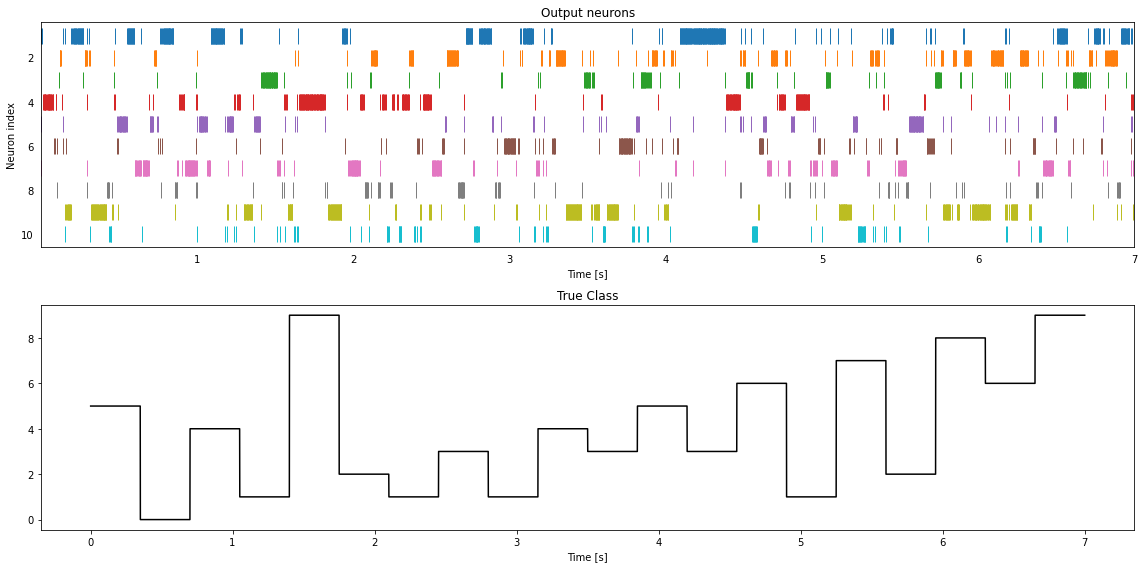

In [93]:
plt.figure(figsize=(16,8))

plt.subplot(2,1,1)
plt.title('Output neurons')
rasterplot(sim.trange(), sim.data[p_layer_1])
plt.xlabel("Time [s]")
plt.ylabel("Neuron index")

plt.subplot(2,1,2)
plt.plot(sim.trange(), sim.data[p_true_label], c='k', label='spikes')
plt.title('True Class')
plt.xlabel("Time [s]")
plt.tight_layout()

plt.savefig(folder+'\outmnist'+str(tstep)+'.png')

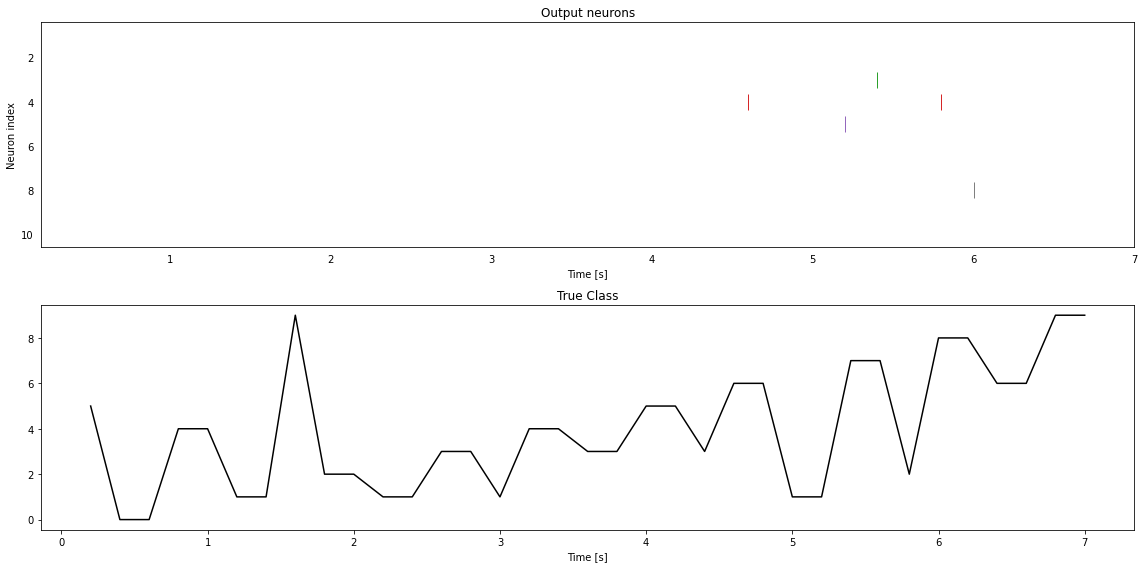

In [82]:
plt.figure(figsize=(16,8))

plt.subplot(2,1,1)
plt.title('Output neurons')
rasterplot(sim.trange(sample_every=0.2), sim.data[p_layer_1])
plt.xlabel("Time [s]")
plt.ylabel("Neuron index")

plt.subplot(2,1,2)
plt.plot(sim.trange(sample_every=0.2), sim.data[p_true_label], c='k', label='spikes')
plt.title('True Class')
plt.xlabel("Time [s]")
plt.tight_layout()

plt.savefig(folder+'\outmnist'+str(tstep)+'.png')

In [ ]:
# for i in range(0,(n_neurons)):
# #     HeatMapSave(sim,folder,connection_layer1_probe,sim.data[connection_layer1_probe].shape[0],i)
#     plt.matshow(np.reshape(weights[200*3][i],(28,28)))
    

In [ ]:
# plt.close()

In [ ]:
def generate_video(img):
    for i in xrange(len(img)):
        plt.imshow(img[i], cmap=cm.Greys_r)
        plt.savefig(folder + "/file%02d.png" % i)

    os.chdir("your_folder")
    subprocess.call([
        'ffmpeg', '-framerate', '8', '-i', 'file%02d.png', '-r', '30', '-pix_fmt', 'yuv420p',
        'video_name.mp4'
    ])
    for file_name in glob.glob("*.png"):
        os.remove(file_name)

In [ ]:
from IPython.display import HTML
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

data = np.random.rand(100,50,50)

fig, ax = plt.subplots()

ax.set_xlim((0, 50))
ax.set_ylim((0, 50))

im = ax.imshow(data[0,:,:])

def init():
    im.set_data(data[0,:,:])
    return (im,)

# animation function. This is called sequentially
def animate(i):
    data_slice = data[i,:,:]
    im.set_data(data_slice)
    return (im,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, blit=True)

HTML(anim.to_html5_video())

In [ ]:
# imports
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2

# Use Agg backend for canvas
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

mat=np.array(weights)

# create OpenCV video writer
video = cv2.VideoWriter('video.mp4', cv2.VideoWriter_fourcc('A','V','C','1'), 1, (mat.shape[0],mat.shape[1]))

# loop over your images
for i in xrange(len(img)):

    fig = plt.figure()
    plt.imshow(img[i], cmap=cm.Greys_r)

    # put pixel buffer in numpy array
    canvas = FigureCanvas(fig)
    canvas.draw()
    mat = np.array(canvas.renderer._renderer)
    mat = cv2.cvtColor(mat, cv2.COLOR_RGB2BGR)

    # write frame to video
    video.write(mat)

# close video writer
cv2.destroyAllWindows()
video.release()

In [ ]:
!pip install opencv-python